## Téléchargement de la base de données

In [112]:
# Pour récupérer le nombre de classes du training dataset
from tensorflow import keras
from tensorflow.keras import layers

In [113]:
path = '/home/basile/Documents/projet_bees_detection_basile/data_bees_detection/benchmark_classification/23_05_VGG16_dense_2'

IMG_SIZE = 224
train_ds = keras.utils.image_dataset_from_directory(
    directory=path + '/train',
    labels='inferred',
    label_mode='categorical',
    shuffle = False,
    batch_size=16,
    image_size=(IMG_SIZE, IMG_SIZE))

Found 8 files belonging to 2 classes.


In [114]:
CLASS_NAMES = train_ds.class_names
print(CLASS_NAMES)
NB_CLASSES = len(CLASS_NAMES)
print(NB_CLASSES)

['Apis mellifera', 'Bombus terrestris']
2


## Chargement des données

In [115]:
from tensorflow import keras
from keras import layers

In [116]:
# Récupération des dataset pour l'entraînement (train, val)
train_ds = keras.utils.image_dataset_from_directory(
    directory=path + '/train',
    labels='inferred',
    label_mode='categorical',
    shuffle = False,
    batch_size=2,
    image_size=(IMG_SIZE, IMG_SIZE))

validation_ds = keras.utils.image_dataset_from_directory(
    directory=path + '/validation/',
    labels='inferred',
    label_mode='categorical',
    batch_size=2,
    image_size=(IMG_SIZE, IMG_SIZE))

Found 8 files belonging to 2 classes.
Found 2 files belonging to 2 classes.


In [117]:
len(train_ds.file_paths)

8

## Création du modèle

In [118]:
# !pip uninstall opencv-python-headless==4.5.5.62
# !pip install opencv-python-headless==4.1.2.30
# !pip install -q -U albumentations
# !echo "$(pip freeze | grep albumentations) is successfully installed"

In [119]:
# from albumentations import (Compose, Rotate, HorizontalFlip, VerticalFlip, Affine, RandomBrightnessContrast, ChannelShuffle)
# import albumentations as A

# AUGMENTATIONS_TRAIN = Compose([
#     Rotate(limit=[0,100], p=0.5),
#     HorizontalFlip(p=0.5),
#     VerticalFlip(p=0.5),
#     Affine(shear=[-45, 45], p=0.5),
#     RandomBrightnessContrast(p=0.5)
# ])

In [120]:
AUGMENTATIONS_TRAIN = None


import numpy as np

x_train = np.array(train_ds.file_paths)
y_train = np.zeros((len(train_ds.file_paths), NB_CLASSES))

ind_data = 0
for bx, by in train_ds.as_numpy_iterator():
  y_train[ind_data:ind_data+bx.shape[0]] = by
  ind_data += bx.shape[0]

In [121]:
def color_preprocessing(x):
    x = x.astype('float32')
    mean = [125.3, 123.0, 113.9]
    std  = [63.0,  62.1,  66.7]
    for i in range(3):
        x[:,:,:,i] = (x[:,:,:,i] - mean[i]) / std[i]
    return x

In [122]:
from keras.utils import Sequence
import numpy as np
import cv2 as cv
import time
import matplotlib.pyplot as plt


class AbeillesSequence(Sequence):
    # Initialisation de la séquence avec différents paramètres
    def __init__(self, x_train, y_train, batch_size, augmentations):
        self.x_train = x_train
        self.y_train = y_train
        self.classes = CLASS_NAMES
        self.batch_size = batch_size
        self.augment = augmentations
        self.indices1 = np.arange(len(x_train))
        np.random.shuffle(self.indices1) # Les indices permettent d'accéder
        # aux données et sont randomisés à chaque epoch pour varier la composition
        # des batches au cours de l'entraînement

    # Fonction calculant le nombre de pas de descente du gradient par epoch
    def __len__(self):
        return int(np.ceil(x_train.shape[0] / float(self.batch_size)))
    
    # Application de l'augmentation de données à chaque image du batch
    def apply_augmentation(self, bx, by):

        batch_x = np.zeros((bx.shape[0], IMG_SIZE, IMG_SIZE, 3))
        batch_y = by
        
        # Pour chaque image du batch
        for i in range(len(bx)):
            class_labels = []
            class_id = np.argmax(by[i])
            class_labels.append(self.classes[class_id])

            # Application de l'augmentation à l'image et aux masques
            img = cv.imread(bx[i])
            img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

            # resize img
            img = cv.resize(img,(IMG_SIZE,IMG_SIZE))

            batch_x[i] = img
           
        return batch_x, batch_y

    # Fonction appelée à chaque nouveau batch : sélection et augmentation des données
    # idx = position du batch (idx = 5 => on prend le 5ème batch)
    def __getitem__(self, idx):

        batch_x = self.x_train[self.indices1[idx * self.batch_size:(idx + 1) * self.batch_size]]
        batch_y = self.y_train[self.indices1[idx * self.batch_size:(idx + 1) * self.batch_size]]
           
        batch_x, batch_y = self.apply_augmentation(batch_x, batch_y)

        # Normalisation des données
        batch_x = color_preprocessing(batch_x)
        
        return batch_x, batch_y

    # Fonction appelée à la fin d'un epoch ; on randomise les indices d'accès aux données
    def on_epoch_end(self):
        np.random.shuffle(self.indices1)

In [123]:
from keras import regularizers
from keras import optimizers
import tensorflow as tf

In [124]:
from tensorflow import keras 
import numpy as np
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import BatchNormalization
from keras.layers import Conv2D, Dense, Input, add, Activation, Flatten, AveragePooling2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D
from keras.callbacks import LearningRateScheduler, TensorBoard
from keras.regularizers import l2
from keras import optimizers
from keras.models import Model

WEIGHT_DECAY = 0.0005

def create_WideResNet50(width=1, img_rows=224, img_cols=224, img_channels=3, nb_classes=1000):

  # Input
  img_input = Input(shape=(img_rows,img_cols,img_channels))

  # first_filter : nb de filtres de la première conv
  # reduction : True si on doit diviser la dimension de l'entrée
  def residual_layer(input, first_filter, reduction=False, first_layer=False):

    conv = Conv2D(filters=width*first_filter, kernel_size=(1,1), strides=(1,1),
        kernel_initializer='he_normal',
        kernel_regularizer=l2(WEIGHT_DECAY))(input)
    conv = BatchNormalization(momentum=0.9, epsilon=1e-5)(conv)
    conv = Activation('relu')(conv)

    if (reduction):
      conv = Conv2D(filters=width*first_filter, kernel_size=(3,3), strides=(2,2), padding='same',
              kernel_initializer='he_normal',
              kernel_regularizer=l2(WEIGHT_DECAY))(conv)
    else:
      conv = Conv2D(filters=width*first_filter, kernel_size=(3,3), strides=(1,1), padding='same',
              kernel_initializer='he_normal',
              kernel_regularizer=l2(WEIGHT_DECAY))(conv)
    conv = BatchNormalization(momentum=0.9, epsilon=1e-5)(conv)
    conv = Activation('relu')(conv)

    conv = Conv2D(filters=4*first_filter, kernel_size=(1,1), strides=(1,1),
            kernel_initializer='he_normal',
            kernel_regularizer=l2(WEIGHT_DECAY))(conv)
    conv = BatchNormalization(momentum=0.9, epsilon=1e-5)(conv)

    if (first_layer):
      conv2 = Conv2D(filters = 256, kernel_size=(1,1), strides=(1,1),
          kernel_initializer='he_normal',
          kernel_regularizer=l2(WEIGHT_DECAY))(x)
      conv2 = BatchNormalization(momentum=0.9, epsilon=1e-5)(conv2)
    else:
      if (reduction):
        conv2 = Conv2D(filters = 4*first_filter, kernel_size=(1,1), strides=(2,2),
                kernel_initializer='he_normal',
                kernel_regularizer=l2(WEIGHT_DECAY))(x)
        conv2 = BatchNormalization(momentum=0.9, epsilon=1e-5)(conv2)
      else:
        conv2 = input
    
    return add([conv, conv2])
  
  x = ZeroPadding2D(padding=(3,3))(img_input)
  x = Conv2D(filters=64, kernel_size=(7,7), strides=(2,2),
        kernel_initializer='he_normal',
        kernel_regularizer=l2(WEIGHT_DECAY))(x)
  x = BatchNormalization(momentum=0.9, epsilon=1e-5)(x)
  x = Activation('relu')(x)
  x = ZeroPadding2D(padding=(1,1))(x)
  x = MaxPooling2D(pool_size=(3, 3), strides=(2,2))(x)

  # Premier bloc résiduel
  x = residual_layer(x, 64, reduction=False, first_layer=True)
  for i in range(2): 
    x = Activation('relu')(x)
    x = residual_layer(x, 64, reduction=False)

  # Second bloc
  x = Activation('relu')(x)
  x = residual_layer(x, 128, reduction=True)
  for i in range(3): 
    x = Activation('relu')(x)
    x = residual_layer(x, 128, reduction=False)
  
  # Troisième bloc
  x = Activation('relu')(x)
  x = residual_layer(x, 256, reduction=True)
  for i in range(5): 
    x = Activation('relu')(x)
    x = residual_layer(x, 256, reduction=False)

  # Quatrième bloc
  x = Activation('relu')(x)
  x = residual_layer(x, 512, reduction=True)
  for i in range(2): 
    x = Activation('relu')(x)
    x = residual_layer(x, 512, reduction=False)

  x = GlobalAveragePooling2D()(x)
  x = Flatten()(x)
  x = Dense(nb_classes,
      activation='softmax',
      kernel_initializer='he_normal',
      kernel_regularizer=l2(WEIGHT_DECAY))(x)
  
  return Model(img_input, x)

In [125]:
model = create_WideResNet50(width=2, img_rows=224, img_cols=224, img_channels=3, nb_classes=NB_CLASSES)
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_10 (ZeroPadding  (None, 230, 230, 3)  0          ['input_6[0][0]']                
 2D)                                                                                              
                                                                                                  
 conv2d_265 (Conv2D)            (None, 112, 112, 64  9472        ['zero_padding2d_10[0][0]']      
                                )                                                           

In [126]:
# Ajout de l'optimiseur, de la fonction coût et des métriques
model.compile(tf.keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9), loss='categorical_crossentropy', metrics=['categorical_accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [127]:
def weight_class_i(nb_elts, nb_class, nb_img):
  return (nb_img/(nb_class*nb_elts))

In [128]:
# # Détermination des poids à attribuer à chaque classe
# import pathlib

# nb_files = 0
# class_weight = {}
# for i in range(nb_classes):
#   for path in pathlib.Path("abeilles-cap500/train/" + class_names[i]).iterdir():
#     if path.is_file():
#         nb_files += 1
#   class_weight[i] = weight_class_i(nb_files, nb_classes, len(train_ds.file_paths))
#   nb_files = 0
# print(class_weight)

In [129]:
# Les callbacks
model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath='./drive/MyDrive/Stage2A/cap500/WideResNet50-2/PoidsWR50-2/best_model_wideresnet50-2',
    save_weights_only=True,
    monitor='val_categorical_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_categorical_accuracy",
    min_delta=0.01,
    patience=10,
    verbose=1,
    mode="auto")

reduce_lr_cb = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.1,
                              patience=5, min_lr=0.00001, verbose=1)

In [130]:
train_ds_aug = AbeillesSequence(x_train, y_train, batch_size=2, augmentations=AUGMENTATIONS_TRAIN)

In [131]:
import numpy as np
import tensorflow as tf


# Normalisation des données de validation
x_val = np.zeros((len(validation_ds.file_paths), IMG_SIZE, IMG_SIZE, 3))
y_val = np.zeros((len(validation_ds.file_paths), NB_CLASSES))

ind_data = 0
for bx, by in validation_ds.as_numpy_iterator():
  x_val[ind_data:ind_data+bx.shape[0]] = bx
  y_val[ind_data:ind_data+bx.shape[0]] = by
  ind_data += bx.shape[0]

x_val = color_preprocessing(x_val)

In [132]:
x_val.shape

(2, 224, 224, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


--------------------------------------------------
class_labels ['Apis mellifera']
[[[163 208  57]
  [165 209  59]
  [164 208  62]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[163 208  54]
  [165 210  57]
  [165 210  62]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[164 209  50]
  [166 211  56]
  [167 212  61]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 ...

 [[  1   0   0]
  [  1   0   0]
  [  1   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
--------------------------------------------------
--------------------------------------------------
class_labels ['Apis mellifera']
class_labels ['Apis mellifera']
[[[165 140  78]
  [160 137  71]
  [151 133  61]
  ...
  [154 161 107]
  [154 161 106]
  [153 161 104]]

 [[165 142  79]
 

error: OpenCV(4.7.0) /io/opencv/modules/highgui/src/window.cpp:1272: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvShowImage'


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


--------------------------------------------------


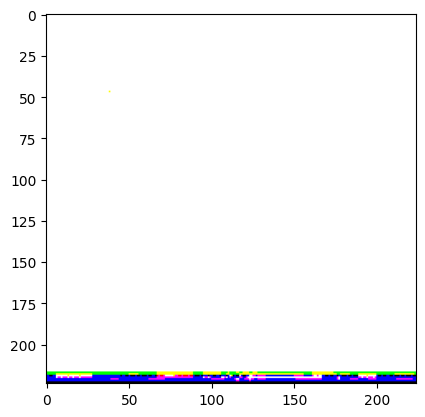

In [133]:
# Sans pondération des classes
history = model.fit(train_ds_aug, epochs=150, validation_data = (x_val, y_val), callbacks=[model_checkpoint_cb, early_stopping_cb, reduce_lr_cb])
# Avec pondération des classes
#model.fit(train_ds_aug, epochs=150, validation_data = (x_val, y_val), callbacks=[model_checkpoint_cb, early_stopping_cb, reduce_lr_cb], class_weight=class_weight)

In [ ]:
import matplotlib.pyplot as plt
def plot_training_analysis(history, metric='loss'):    

  loss = history.history[metric]
  val_loss = history.history['val_' + metric]

  epochs = range(len(loss))

  plt.plot(epochs, loss, 'b', linestyle="--",label='Training ' + metric)
  plt.plot(epochs, val_loss, 'g', label='Validation ' + metric)
  plt.title('Training and validation ' + metric)
  plt.legend()

  plt.show()

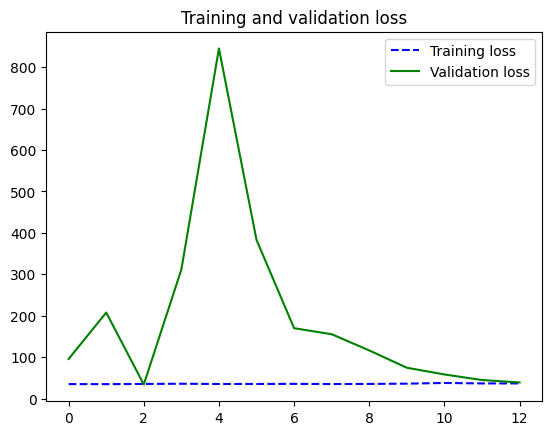

In [ ]:
plot_training_analysis(history)

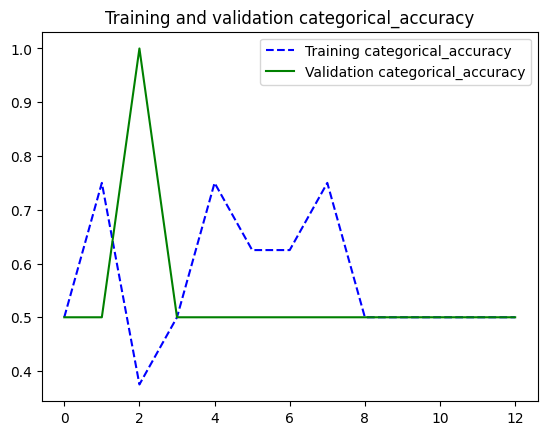

In [ ]:
plot_training_analysis(history,metric='categorical_accuracy')